# 1. Testing loading high resolution outputs from IFS Cycle 3
# 2. Loading detected blocking and plotting masks

In [1]:
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake
import numpy as np
import matplotlib.pylab as plt
import xarray as xr

/home/b/b382006/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import sys, os, argparse
#import bottleneck
sys.path.append('/home/b/b382006/tools/util')
from basic_functions import eliassen_palm_flux_sphere, temp_to_theta


In [3]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )


In [4]:
def convert_to_xarray(ds,var,lev,date):
    # select a variable, reshape lat lon and convert to XArray DataArray
    # needs to specify an existing varname e.g. '2t'
    # assumes that ds has the shape time | value
    
    # arrange value coordinate into lat/lon
    if lev=='sfc':
        sample = np.reshape(ds[var].values,(len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    else:
        sample = np.reshape(ds[var].sel(time=date,level=lev).values,(len(np.unique(ds.lat)),len(np.unique(ds.lon))))
    
    # create DataArray with proper name, dimensions, and coordinates
    da = xr.DataArray(
        data=sample,
        name=var,
        dims=["lat", "lon"],
        coords=dict(
            lon=(["lon"], np.unique(ds.lon)),
            # lat=(["lat"], np.unique(ds.lat)),
            lat=(["lat"], np.unique(ds.lat)[::-1]), # use this because otherwise lats are flipped; only comment for testing
        ),
        attrs=dict(
            ds[var].attrs,
        ),
    )
    
    
    return da



In [5]:
#####Take a domain
def coll_reg(data,latitude,longitude):
    dsel = data.where(((data.lat>=latitude[0]) & (data.lat<=latitude[1])) & ((data.lon>=longitude[0]) & (data.lon<=longitude[1])),drop=True)
    #dsel = data.where(((data.lat==latitude)) & ((data.lon>=longitude[0]) & (data.lon<=longitude[1])),drop=True)

    return dsel

In [6]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [7]:
cat.IFS

IFS:
  args:
    path: https://data.nextgems-h2020.eu/IFS/main.yaml
  description: IFS model output
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://data.nextgems-h2020.eu


In [8]:
# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'IFS_4.4-FESOM_5-cycle3'?
print(list(cat.IFS))
print(list(cat.IFS['IFS_4.4-FESOM_5-cycle3'])) # tco2559-ng5-cycle3 will soon be removed
#print(list(cat.IFS['IFS_9-NEMO_25-cycle3'])) # tco2559-ng5-cycle3 will soon be removed

['IFS_9-FESOM_5-production', 'IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_28-FESOM_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']
['2D_1h_native', '3D_1h6h_native', '2D_monthly_native', '3D_monthly_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', '2D_1h_0.25deg', '3D_1h6h_0.25deg', '2D_monthly_1deg', '3D_monthly_1deg', '2D_1h_1deg', '3D_1h6h_1deg', 'WAM_1h_native']


In [9]:
data = cat.IFS['IFS_4.4-FESOM_5-cycle3']['3D_1h6h_1deg'].to_dask().pipe(attach_coords) # load lower-resolution here, monthly means
#data_2d = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_1h_1deg'].to_dask() # load lower-resolution here, monthly means


In [11]:
#data

In [12]:
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array for regridded data
#date='2023-02-13T18:00:00' #20230213_18
#date='2020-01-21T06:00:00' #20200121_06
date='2021-01-17T00:00:00' #20210117_00


var1 = convert_to_xarray(data,var='q',lev=700.0,date=date)

In [13]:
var2 = convert_to_xarray(data,var='z',lev=500.0,date=date)
#(var2*1000).max()

In [14]:
uvar3 = convert_to_xarray(data,var='u',lev=250.0,date=date)
vvar3 = convert_to_xarray(data,var='v',lev=250.0,date=date)
#/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5/z500

u=uvar3
v=vvar3
lons, lats = np.meshgrid(u.lon, u.lat)

In [15]:
### Working with precupitation

#pcp=data.tp.sel(time=data.tp.time.dt.month.isin([7]))
#data =pcp.sel(time=pcp.time.dt.year.isin([2020]))
#data

#dsel_diff = pcp.diff('time')
##dsel_diff
#pcp = xr.where(dsel_diff > 0, dsel_diff, None)

#pcp_max=pcp[0:200,:].max(dim='time').compute()
#pcp_max=pcp[15,:]



## Load detected blockings with contrack

In [33]:
full_ifs = xr.open_dataset('/work/bm1235/b382006/regridding/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs-ngc2013-2021.nc')

ano = xr.open_dataset('/scratch/b/b382006/nextgems/cycle3/IFS_4.4-FESOM_5-cycle3/z500/ifs-c3-anom-z500_2021.nc')


In [17]:
import pandas as pd
block_df =  pd.read_csv('/work/bm1235/b382006/regridding/cycle3/IFS_4.4-FESOM_5/block/ANO_Z500/BLOCKS-ifs-ngc2013-2021.csv', delimiter=',',header=0)


### Find bid (flag of most intense blockings) 
block_df.loc[block_df['Intensity'].nlargest(10).index]

,Flag,Date,Longitude,Latitude,Intensity,Size
64,2,20210117_00,185,51,313.00,8990423.45
63,2,20210116_18,185,51,311.14,8832706.45
65,2,20210117_06,185,51,310.23,8911314.86
62,2,20210116_12,185,51,307.79,8602807.08
78,2,20210120_12,186,50,305.52,8245874.49
77,2,20210120_06,186,50,304.45,8493577.83
79,2,20210120_18,187,51,304.40,8078302.81
66,2,20210117_12,186,51,304.39,8973558.05
76,2,20210120_00,185,49,303.18,8723677.92
75,2,20210119_18,185,49,300.84,8934532.55


In [18]:
###==2021
bid=2
###==2022
###==2023
#bid=120

mdate = date[0:4] + date[5:7] + date[8:10] + '_' + date[11:13]
lonts = np.asarray(block_df['Longitude'].iloc[np.where(block_df['Flag']==bid)])
latts = np.asarray(block_df['Latitude'].iloc[np.where(block_df['Flag']==bid)])
dates = np.asarray(block_df['Date'].iloc[np.where(block_df['Flag']==bid)])
dates
#latts

array(['20210101_00', '20210101_06', '20210101_12', '20210101_18',
       '20210102_00', '20210102_06', '20210102_12', '20210102_18',
       '20210103_00', '20210103_06', '20210103_12', '20210103_18',
       '20210104_00', '20210104_06', '20210104_12', '20210104_18',
       '20210105_00', '20210105_06', '20210105_12', '20210105_18',
       '20210106_00', '20210106_06', '20210106_12', '20210106_18',
       '20210107_00', '20210107_06', '20210107_12', '20210107_18',
       '20210108_00', '20210108_06', '20210108_12', '20210108_18',
       '20210109_00', '20210109_06', '20210109_12', '20210109_18',
       '20210110_00', '20210110_06', '20210110_12', '20210110_18',
       '20210111_00', '20210111_06', '20210111_12', '20210111_18',
       '20210112_00', '20210112_06', '20210112_12', '20210112_18',
       '20210113_00', '20210113_06', '20210113_12', '20210113_18',
       '20210114_00', '20210114_06', '20210114_12', '20210114_18',
       '20210115_00', '20210115_06', '20210115_12', '20210115_

In [19]:
#full_ifs.flag.sel(time=date).max()

In [20]:
#flevels=[119.5, 120.5] ### flag
#flevels=[3045,3046] ### flag
flevels=[1.5, 2.5] ### flag

<Figure size 2100x900 with 0 Axes>

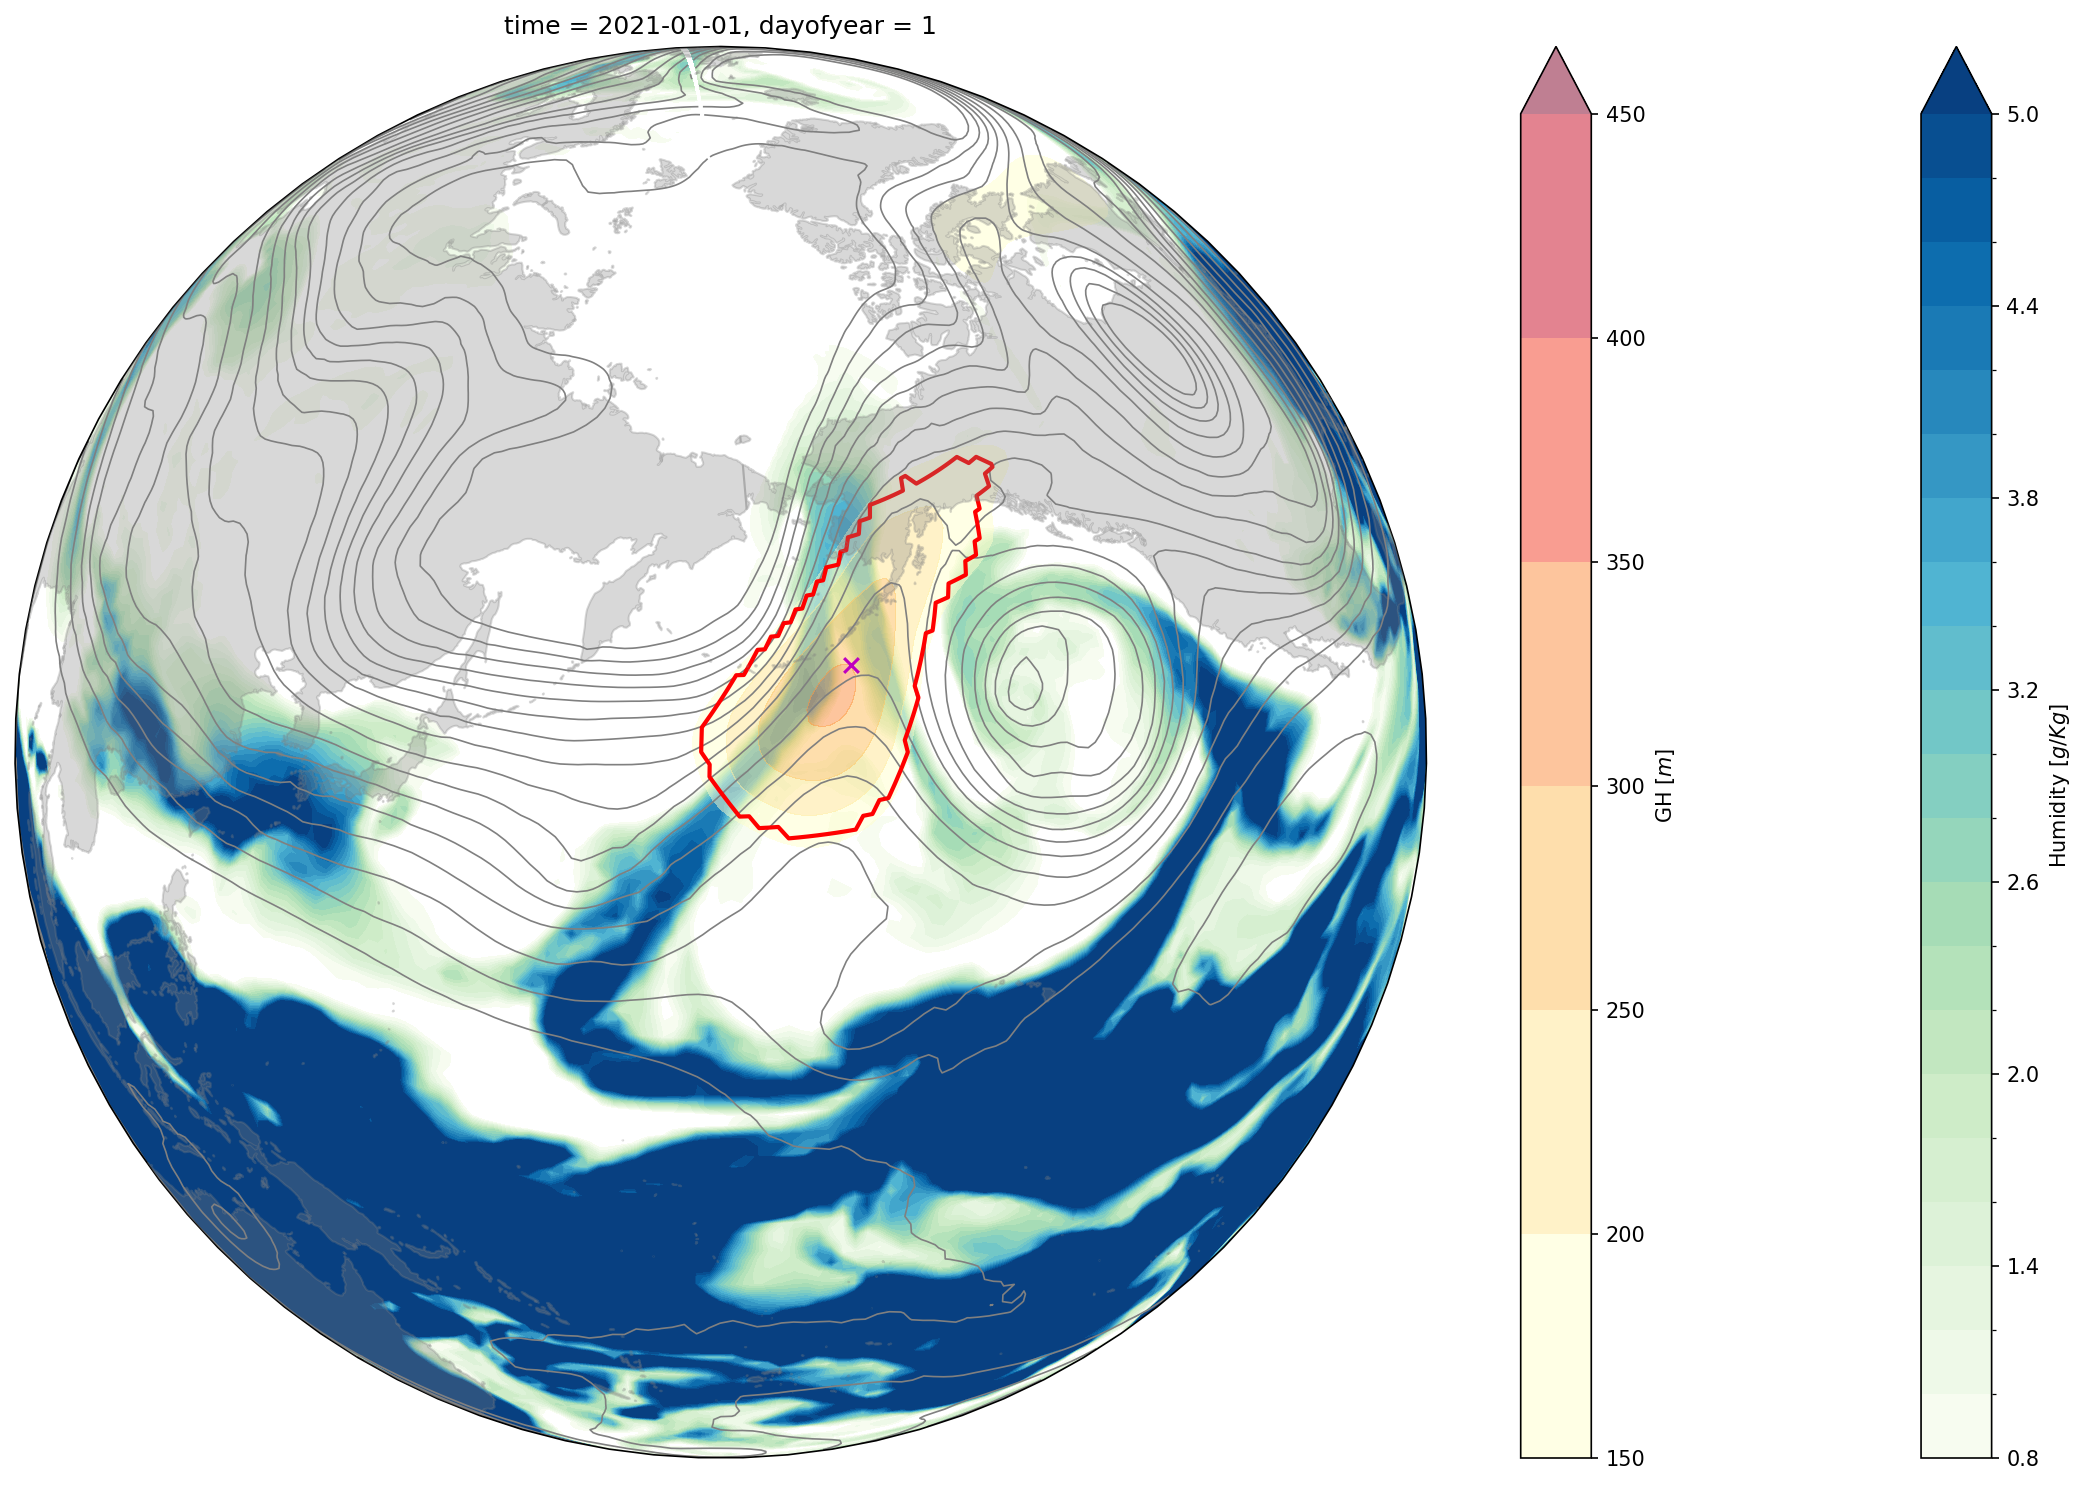

In [39]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.patches as mpatches
import matplotlib.path as mpath

plt.figure(figsize=(14,6),dpi=150)
#fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})
#lon_0 = -35.0
#lat_0 =  70.0
lon_0 = -185.0
lat_0 =  45
fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection':  ccrs.Orthographic(lon_0, lat_0)})
#plotproj = ccrs.Orthographic(central_longitude=90, central_latitude=45)
ax.set_global()

#ax=plt.axes(projection=ccrs.PlateCarree())
# subplot_kw={'projection': ccrs.Orthographic(lon_0, lat_0)}

### Compute a circle in axes coordinates, which we can use as a boundary
### for the map. We can pan/zoom as much as we like - the boundary will be
### permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

##prec
#(var7*30*60*24).plot.contourf(ax=ax, levels=np.arange(2,16,1), cmap='GnBu', alpha=0.80,extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'pr [$mm/day$]'})
##humidity
(var1*1000).plot.contourf(ax=ax, levels=np.arange(0.8,5.2,0.2), cmap='GnBu',extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'Humidity [$g/Kg$]'})
#(temp-273).plot.contourf(ax=ax, levels=np.arange(-20,30,2), cmap='twilight',extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'SLP[$hPa$]'})

(var2).plot.contour(ax=ax, levels=np.arange(50000,60000,500), colors='grey',linewidths=0.8, transform=ccrs.PlateCarree())

### geop anomaly
ano.z.sel(time=date).plot.contourf(ax=ax, levels=np.arange(150,500,50), cmap='YlOrRd',alpha=0.50, extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'GH [$m$]'})

### Wind
#q = ax.quiver(lons, lats, u.values, v.values, transform=ccrs.PlateCarree(), color="k", angles="xy",regrid_shape=50)
#qk = ax.quiverkey (q, 0.96, 1.02, 3.0, '3.0 m/s')


###Blockings
#flevels=[119.5, 120.5] ### flag
rlevels=[0.5,1.5]
im1=full_ifs.flag.sel(time=date).plot.contour(ax=ax,levels=flevels,colors='r',linewidths=2,extend = 'neither', transform=ccrs.PlateCarree())

# cosmetic: sometimes there is a gap near map edge where track is split:
lonts[lonts >= 355] = 359.9
lonts[lonts <= 3] = 0.1
segment = np.vstack((lonts,latts))

#move longitude into the map region and split if longitude jumps by more than "threshold"
lon0 = 0 #center of map
bleft = lon0-0.
bright = lon0+360
segment[0,segment[0]> bright] -= 360
segment[0,segment[0]< bleft]  += 360
threshold = 180  # CHANGE HERE
isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]
subsegs = np.split(segment,isplit+1,axis=+1)

#plot the tracks
for seg in subsegs:
    x,y = seg[0],seg[1]
    ax.plot(x ,y,c = 'm',linewidth=2, transform=ccrs.PlateCarree())

ax.scatter(lonts[0],latts[0],s=50,c='m',marker="x", zorder=10, transform=ccrs.PlateCarree())


#ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree()); 

#ax.coastlines('110m', alpha=0.5)
import cartopy.feature as cfeature
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey',alpha=0.30),zorder=20)

###=== Add colorbar
#cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.02])  # Left, bottom, width, height.
#cbar = fig.colorbar(im1, cax=cbar_ax, extend='both', orientation='horizontal')
#cbar.set_label(' Blocking (%)')

plt.tight_layout()


### Save
#plt.savefig('/home/b/b382006/figures/humidity_block_ifs_4.4-fesom_5-'+date+'.jpg')

In [46]:
#### Stratosphere


###2021
###So 2021-01-01 to 2021-12-31
ssw_2021_ta = data.t.sel(time=slice('2022-07-01', '2023-07-31'), level=10.0)
ssw_2021_ua = data.u.sel(time=slice('2022-07-01', '2023-07-31'), level=10.0)


###Select a region
lons = 0., 360
lats = 60., 90. # 60, 90?
#lats = 60.


box_ta=coll_reg(ssw_2021_ta,lats,lons)
box_ua=coll_reg(ssw_2021_ua,lats,lons)
#ssw_2021_ta

#domain average
box_ave_ta = box_ta.mean(axis=1).compute()
box_ave_ua = box_ua.mean(axis=1).compute()

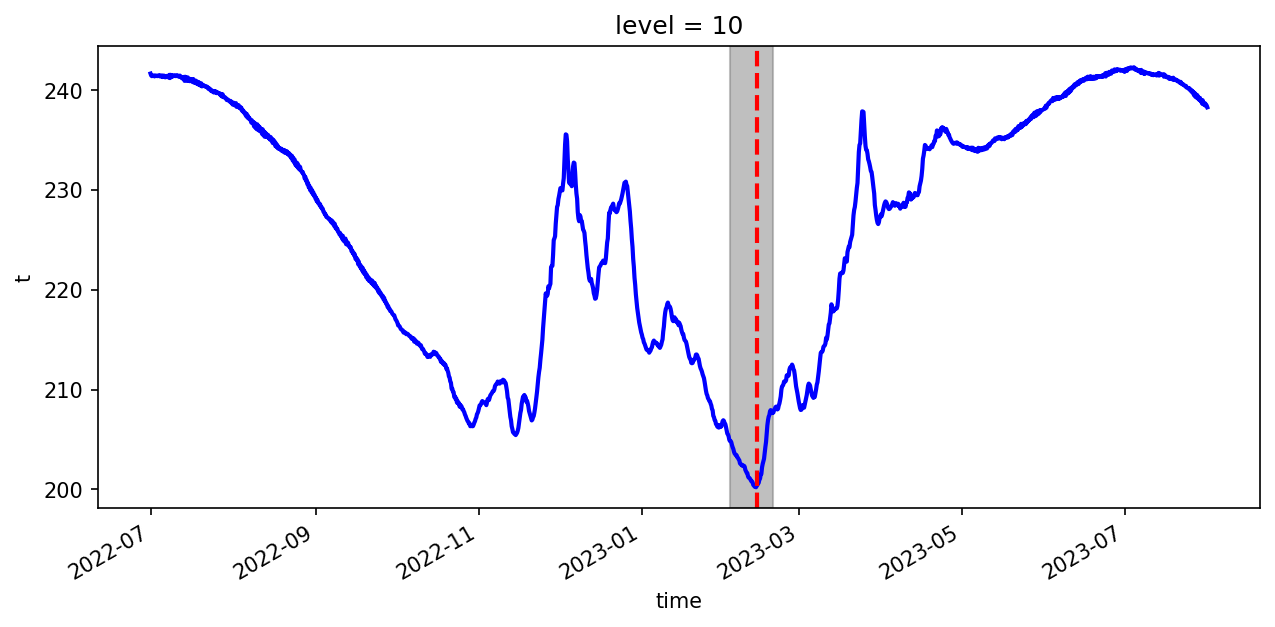

In [53]:
import pandas as pd
fig,ax=plt.subplots(figsize=(10, 4), dpi=150, )

box_ave_ta.plot(color='b', linestyle='-', lw=2)
ax.axvline(pd.to_datetime('2023-02-13'), color='r', linestyle='--', lw=2)
ax.axvspan('2023-02-03','2023-02-19', color='grey', alpha=0.5, zorder=-1)
#20230203_12, '20230219_00'

#box_ave_ua.plot(color='k', linestyle='-', lw=2)
#ax.axhline(0, color='r', linestyle='--', lw=0.5)

In [55]:
### Do a loop
### test plot
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.patches as mpatches
import xarray as xr
import matplotlib.path as mpath

In [33]:
'20210101_00','20210202_18'

('20210101_00', '20210202_18')

In [41]:
 var1

<xarray.DataArray 'q' (lat: 181, lon: 360)>
array([[0.00016375, 0.00016375, 0.00016375, ..., 0.00016403, 0.00016375,
        0.00016375],
       [0.00015979, 0.00015965, 0.00015962, ..., 0.00016019, 0.00015996,
        0.00015993],
       [0.00015534, 0.00015584, 0.00015615, ..., 0.00015386, 0.00015427,
        0.00015481],
       ...,
       [0.00054133, 0.00054006, 0.00053874, ..., 0.00054109, 0.00054084,
        0.00054142],
       [0.00048393, 0.00048281, 0.0004815 , ..., 0.00048732, 0.0004865 ,
        0.00048508],
       [0.00047694, 0.00047694, 0.00047694, ..., 0.00047708, 0.00047694,
        0.00047694]])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
Attributes: (12/16)
    paramId:                    133
    dataType:                   fc
    numberOfPoints:             65160
    typeOfLevel:                isobaricInhPa
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfName:                     specific_humidity
    cfVarName:                  q
    missingValue:               3.4028234663852886e+38
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Latitude/Longitude Grid

In [42]:
### interpolated grid
### Compute a circle in axes coordinates, which we can use as a boundary
### for the map. We can pan/zoom as much as we like - the boundary will be
### permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
    
ini=0
for i in range(1,31):
    ###date='2023-02-13T18:00:00'
    #date='2023-02-'+str(i).zfill(2)+'T12:00:00'
    date='2021-01-'+str(i).zfill(2)+'T00:00:00'
    mdate = date[0:4] + date[5:7] + date[8:10] + '_' + date[11:13]
    print(date, mdate, ini)
    
# get ttr, tsr, 2t and reshape to (#lat x #lon) numpy array for regridded data
    var1 = convert_to_xarray(data,var='q',lev=700.0,date=date)
    var2 = convert_to_xarray(data,var='z',lev=500.0,date=date)

    uvar3 = convert_to_xarray(data,var='u',lev=250.0,date=date)
    vvar3 = convert_to_xarray(data,var='v',lev=250.0,date=date)

    u=uvar3
    v=vvar3
    lons, lats = np.meshgrid(u.lon, u.lat)
    
#    lons = np.asarray(block_df['Longitude'].loc[(block_df['Flag']==bid) & (block_df['Date']==mdate)])
#    lats = np.asarray(block_df['Latitude'].loc[(block_df['Flag']==bid) & (block_df['Date']==mdate)])    
    lonts = np.asarray(block_df['Longitude'].iloc[np.where(block_df['Flag']==bid)])
    latts = np.asarray(block_df['Latitude'].iloc[np.where(block_df['Flag']==bid)])
    latts= latts[0:ini+1]
    lonts= lonts[0:ini+1]
    ini=ini+3
####tcsw.min()

  
    fig=plt.figure(figsize=(14,6),dpi=150)
    
    lon_0 = -35.0
    lat_0 =  70.0
    fig,ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection':  ccrs.Orthographic(lon_0, lat_0)})
#    fig, ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})

#    ax.set_boundary(circle, transform=ax.transAxes)

    (var1*1000).plot.contourf(ax=ax, levels=np.arange(0.8,5.2,0.2), cmap='GnBu',extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'Humidity [$g/Kg$]'})
#(temp-273).plot.contourf(ax=ax, levels=np.arange(-20,30,2), cmap='twilight',extend = 'both', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'SLP[$hPa$]'})
    (var2).plot.contour(ax=ax, levels=np.arange(50000,60000,500), colors='grey',linewidths=0.8, transform=ccrs.PlateCarree())

    ### geop anomaly
    ano.z.sel(time=date).plot.contourf(ax=ax, levels=np.arange(150,500,50), cmap='YlOrRd',alpha=0.50, extend = 'max', transform=ccrs.PlateCarree(),add_colorbar=True,cbar_kwargs={'label': 'GH [$m$]'})

    q = ax.quiver(lons, lats, u.values, v.values, transform=ccrs.PlateCarree(), color="k", angles="xy",regrid_shape=50)
    qk = ax.quiverkey (q, 0.96, 1.02, 3.0, '3.0 m/s')
    
    
    ###Blockings
#    flevels=[119.5, 120.5] ### flag
    rlevels=[0.5,1.5]
    im1=full_ifs.flag.sel(time=date).plot.contour(ax=ax,levels=flevels,colors='r',linewidths=2,extend = 'neither', transform=ccrs.PlateCarree())

# cosmetic: sometimes there is a gap near map edge where track is split:
    lonts[lonts >= 355] = 359.9
    lonts[lonts <= 3] = 0.1
    segment = np.vstack((lonts,latts))

#move longitude into the map region and split if longitude jumps by more than "threshold"
    lon0 = 0 #center of map
    bleft = lon0-0.
    bright = lon0+360
    segment[0,segment[0]> bright] -= 360
    segment[0,segment[0]< bleft]  += 360
    threshold = 180  # CHANGE HERE
    isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]
    subsegs = np.split(segment,isplit+1,axis=+1)

#plot the tracks
    for seg in subsegs:
        x,y = seg[0],seg[1]
        ax.plot(x ,y,c = 'm',linewidth=2, transform=ccrs.PlateCarree())

    ax.scatter(lonts[0],latts[0],s=50,c='m',marker="x", zorder=10, transform=ccrs.PlateCarree())

    
#    ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); 
    import cartopy.feature as cfeature
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey',alpha=0.30),zorder=20)

    
    ax.coastlines()

    plt.tight_layout()

### Save
    fig.savefig('/home/b/b382006/figures/humidity_block_ifs_4.4-fesom_5-'+date+'.jpg')
    plt.close()

2021-01-01T00:00:00 20210101_00 0
2021-01-02T00:00:00 20210102_00 3
2021-01-03T00:00:00 20210103_00 6
2021-01-04T00:00:00 20210104_00 9
2021-01-05T00:00:00 20210105_00 12
2021-01-06T00:00:00 20210106_00 15
2021-01-07T00:00:00 20210107_00 18
2021-01-08T00:00:00 20210108_00 21
2021-01-09T00:00:00 20210109_00 24
2021-01-10T00:00:00 20210110_00 27
2021-01-11T00:00:00 20210111_00 30
2021-01-12T00:00:00 20210112_00 33
2021-01-13T00:00:00 20210113_00 36
2021-01-14T00:00:00 20210114_00 39
2021-01-15T00:00:00 20210115_00 42
2021-01-16T00:00:00 20210116_00 45
2021-01-17T00:00:00 20210117_00 48
2021-01-18T00:00:00 20210118_00 51
2021-01-19T00:00:00 20210119_00 54
2021-01-20T00:00:00 20210120_00 57


/tmp/ipykernel_1514526/759551129.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1, 1, figsize=(16, 10), dpi=150, subplot_kw={'projection':  ccrs.Orthographic(lon_0, lat_0)})


2021-01-21T00:00:00 20210121_00 60


/tmp/ipykernel_1514526/759551129.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(14,6),dpi=150)


2021-01-22T00:00:00 20210122_00 63
2021-01-23T00:00:00 20210123_00 66
2021-01-24T00:00:00 20210124_00 69
2021-01-25T00:00:00 20210125_00 72
2021-01-26T00:00:00 20210126_00 75
2021-01-27T00:00:00 20210127_00 78
2021-01-28T00:00:00 20210128_00 81
2021-01-29T00:00:00 20210129_00 84
2021-01-30T00:00:00 20210130_00 87


<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

<Figure size 2100x900 with 0 Axes>

In [6]:
###== eliassen_palm_flux
#temp_to_theta
#eliassen_palm_flux_sphere